# **Modeling**

**Import Packages**

In [340]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.ensemble import RandomForestClassifier

import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.multiprocessing as mp

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.activations import relu, softmax
from tensorflow.keras.utils import to_categorical


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV

plt.style.use('dark_background')

**Set the Directory**

In [7]:
# Change the directory to Capstone 2
os.chdir(r'C:\Users\jdrel\OneDrive\Documents\Data_Science\Springboard\Capstone-2')

**Load the Data**

In [3]:
# Import the small training set
small_train = pd.read_csv('./data/processed/small_train.csv')

# Import the small test set
small_test = pd.read_csv('./data/processed/small_test.csv')

# Import the small training set
big_train = pd.read_csv('./data/processed/big_train.csv')

# Import the small test set
big_test = pd.read_csv('./data/processed/big_test.csv')

Now that I have loaded the datasets, I need to separate out the features (X) from the target variable (y) so that it is easy to run the models. 

In [120]:
# Create the X which is only features in the training data
X_small = small_train.drop(['labels', 'group'], axis = 1)
# Create X small for the test set
X_small_test = small_test.drop(['labels', 'group'], axis = 1)
# Do the same thing for the bigger data set
X_big = big_train.drop(['labels', 'group'], axis = 1)
# Create X big for the test set
X_big_test = big_test.drop(['labels'], axis = 1)
# Create the binary y for the training set.
y_train_binary = pd.DataFrame(np.where(small_train['labels'] == 'normal.', 0, 1), columns = ['Binary'])
# Combine labels and binary so that I can analyze which intrusions did well
y_train = pd.concat([small_train['labels'], y_train_binary], axis = 1)
# Create the binary y for the test set
y_test_binary = pd.DataFrame(np.where(small_test['labels'] == 'normal.', 0, 1), columns= ['Binary'])
# Combine labels and binary so that I can analyze which intrusions did well
y_test = pd.concat([small_test['labels'], y_test_binary], axis = 1)

## **Neural Network**

I wanted to use a gpu for my neural network to speed up the processing significantly. I first tried Keras since that is the simplest API for deeep learning in Python. Unfortunately tensorflow-gpu has discontinued support for Windows so I would have to downgrade of many of the packages in this environment to be compatible with an older version of tensorflow-gpu that is Windows compatible. 

I then saw that while tensorflow-gpu doesn't support Windows, it still supports Linux. I installed Windows Subsystem for Linux (WSL) and tried a remote session in VScode through Linux to use tensorflow gpu. After many failed attempts of a crashed kernel, I was able to get my gpu to run the neural networks with tensorflow in the Linux distribution in WSL. Sadly it took significantly longer to run tensorflow-gpu in Linux than it did to run tensorflow on the cpu in Windows. The WSL Linux system is missing many of the GPU optimizations that would make it faster than the cpu. I did not have the time to figure out how to optimize the GPU for WSL.

My last hope was to try Pytorch on Windows since Pytorch hasn't discontinued Windows support. I don't know how to use Pytorch well but since I have already built the models with the Keras API, I asked chatGPT to translate from Keras to Pytorch. The translation wasn't perfect but after a few fixes I ran the neural net with Pytorch on the GPU. This did not accelerate the run time because there is an initial time cost of converting the model to the GPU before it can run. 

Below I test to see if Pytorch is able to detect my NVIDIA GPU

In [8]:
# Check if GPU is available
if torch.cuda.is_available():
    device = torch.device("cuda")  # Use the GPU
    print("GPU is available")
else:
    device = torch.device("cpu")  # Use the CPU
    print("GPU is not available, using CPU")

GPU is available


My computer has two GPUs. An Intel GPU for videos and graphics in normal computing and an NVIDIA GPU for gaming. The code below is to set the GPU that Pytorch is using to NVIDIA.

In [9]:
# Set the GPU through the name cuda
torch.device("cuda")

device(type='cuda')

#### **Define Model Functions**

Now I can create a training function similar to the .fit method in Keras so that everytime I need to use this neural net I can call the function.

In [258]:
# Create a fit function that takes the X-train, y-train, epochs and Batch Size and fits the model
def train_model(X_train, y_train, epochs, batch_sizes, net):
    y_train = np.array(y_train['Binary'])

    # Create an instance of the model with the correct input_dim
    model = net(X_train.shape[1])

    # Check if the GPU is available and save it to device. If not use the cpu
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # Move the model over to the device that is available
    model.to(device)

    # Define the loss function
    criterion = nn.BCELoss()

    # Define the optimizer
    optimizer = optim.Adam(model.parameters())

    X_train_tensor = torch.Tensor(X_train.values).float().to(device)
    y_train_tensor = torch.Tensor(y_train).float().to(device)

    # Training loop
    num_epochs = epochs
    batch_size = batch_sizes
    global losses
    losses = []
    for epoch in range(num_epochs):
        # Shuffle the data at the start of each epoch
        indices = np.random.permutation(len(X_train_tensor))
        shuffled_X = X_train_tensor[indices]
        shuffled_y = y_train_tensor[indices]
        
        # Set the model to training mode
        model.train()

        # Mini-batch training
        for i in range(0, len(X_train_tensor), batch_size):

            batch_X = shuffled_X[i:i+batch_size]
            batch_y = shuffled_y[i:i+batch_size]

            # Forward pass
            outputs = model(batch_X)
            outputs = outputs.view(-1)
            loss = criterion(outputs, batch_y)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Compute accuracy
            predicted_labels = (outputs > 0.5).float()
            accuracy = (predicted_labels == batch_y).float().mean()
        

            # Print loss and accuracy
            print(f'\rEpoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(X_train_tensor)}], Loss: {loss.item():.4f}, Accuracy: {accuracy.item():.4f}', end = '\r')
        
        losses.append(loss.item()) # type: ignore
    
    return model

I can also create a function that plots the loss function from each training epoch so that I can see how well the model trains.

In [14]:
# Create a function that takes in the loss from the train_model as an argument
def loss_plot(loss):
    # Create a plot of the the epics and the losses for each epoch
    plt.plot(range(1,len(loss) + 1), loss);
    # Match the ticks to the epochs
    plt.xticks(np.arange(1, len(loss) + 1));
    # Label the x-axis of the graph
    plt.xlabel("Epoch #");
    # Label the y-axis of the graph
    plt.ylabel("Cost");
    # Title the graph
    plt.title("Model Cost");

And finally I can create a function to evaluate the model with a given test set.

In [151]:
# Create a function to evaluate the model
def eval_model(X_test, y_test, model):
    # Set the model to evaluation mode
    model.eval()

    # Move the model and data back to the CPU
    model.to("cpu")
    X_test_tensor = torch.Tensor(X_test.values).float()

    # Make Preds a global variable for the roc graph
    global preds
    # Perform predictions on the test set
    with torch.no_grad():
        preds = model(X_test_tensor)

    # Convert the predictions tensor to a numpy array
    preds = preds.numpy()

    # Classify the predicitions as 0 or 1 since the values the sigmoid produces are not exact
    preds = np.where(preds < .5, 0, 1)

    # Print the classification report 
    print(classification_report(y_test['Binary'], preds))

In [296]:
# Define a function that examines how the new intrusion types did
def ints_eval(preds, test, multi = False, mask = True):
    global new_attacks
    # Create a list of all the new attack types. This list was taken from preprocessing notebook
    new_attacks = ['xsnoop.', 'udpstorm.', 'mscan.', 'named.', 'processtable.', 'xlock.', 'snmpgetattack.', 
               'snmpguess.', 'worm.', 'ps.', 'httptunnel.', 'sendmail.', 'saint.', 'mailbomb.', 'apache2.', 'xterm.', 'sqlattack.']
    if mask == True:
        mask = test['labels'].isin(new_attacks)
        # create a dataframe that is a column of labels that only has the new labels
        new_labels = pd.DataFrame(test['labels'][mask], columns = ['labels']).reset_index(drop=True)
        # create a dataframe that is a column of labels that only has the predictions
        pred_df = pd.DataFrame(preds[mask], columns = ['pred']).reset_index(drop=True)
        # Combine the labels and the predictions for analysis
        new_intrusions = pd.concat([new_labels, pred_df], axis = 1)
    else:
        # create a dataframe that is a column of labels that only has the new labels
        new_labels = pd.DataFrame(test['labels'], columns = ['labels']).reset_index(drop=True)
        # create a dataframe that is a column of labels that only has the predictions
        pred_df = pd.DataFrame(preds, columns = ['pred']).reset_index(drop=True)
        # Combine the labels and the predictions for analysis
        new_intrusions = pd.concat([new_labels, pred_df], axis = 1)
    # For binary evaluation
    if multi == False:
        # Run value counts when the prediction is positive to see which new intrusions the model captures
        cni = new_intrusions.loc[new_intrusions['pred'] == 1, 'labels'].value_counts()
        # Run value counts when the prediction is negative to see which new intrusions the model doesn't capture
        wni = new_intrusions.loc[new_intrusions['pred'] == 0, 'labels'].value_counts()
    # If this is a multiclass evaluation
    else:
        # Initialize cni and wni as pandas series
        cni = pd.Series()
        wni = pd.Series()
        # iterate through the different labels of the dataset
        for label in test['label'].unique():
            # Iterate through all the predictions
            for i in range(len(preds)):
                # Select all the correct predictions
                if preds[i] == test['group'][i]:
                    # Add 1 to the count everytime there is a correct prediction
                    cni[label] += 1
                # If it isn't correct
                else:
                    # Add one to the incorrect guesses
                    wni[label] +=1
    # Join the right and wrong counts
    deep_dive = pd.concat([cni,wni],axis = 1)
    # Change the column names to indicate what the counts mean
    deep_dive.columns = ["Correct", "Wrong"]
    # fill in the NaN values since some attacks had no correct predictions
    deep_dive = deep_dive.fillna(0)
    # Convert the correct column to the integer type
    deep_dive["Correct"] = deep_dive["Correct"].astype(int)
    # Create a Net column to show the best and worst new intrusions for the model
    deep_dive["Net"] = deep_dive["Correct"] - deep_dive["Wrong"]
    # Create a column showing the percent correct
    deep_dive["% Correct"] = round(deep_dive['Correct']/(deep_dive['Correct'] + deep_dive['Wrong'])*100,1)
    # Convert the wrong column to the integer type
    deep_dive["Wrong"] = deep_dive["Wrong"].astype(int)
    # Convert the net column to the integer type
    deep_dive["Net"] = deep_dive["Net"].astype(int)
    # return the data frame
    return deep_dive

#### **Neural Net Architecture**

Pytorch is different from Keras as I have to define a class and then specify the methods in order to create the neural network. Below I have created a model with 4 hidden layers that each have 12 nodes. I started out having as many nodes as features and then creating a decent amount of hidden layers. If the model is having significant problems in training, I will try different model architectures. 

In [11]:
# Define the model class Net from the parent class nn.Module
class Net(nn.Module):
    # Initialize the class with 
    def __init__(self, input_dim):
        # Initialize nn.Module with super
        super(Net, self).__init__()
        # Create the first layer of the neural net
        self.fc1 = nn.Linear(input_dim, 12)
        # Create the middle layers of the network with 12 nodes that connect to 12 nodes
        self.fc2 = nn.Linear(12, 12)
        self.fc3 = nn.Linear(12, 12)
        self.fc4 = nn.Linear(12, 12)
        # Create a layer that has 12 nodes that connect to 8 nodes
        self.fc5 = nn.Linear(12, 8)
        # Create the last layer that takes 8 nodes and compresses it down to 1
        self.fc6 = nn.Linear(8, 1)
        self.activation = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    # Define a method for the forward propagation of the model
    def forward(self, x):
        # Create the connections 
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.activation(self.fc3(x))
        x = self.activation(self.fc4(x))
        x = self.activation(self.fc5(x))
        x = self.sigmoid(self.fc6(x))
        return x

### **Small Data**

The first model that I'm going to create will use only the training data. The official test set contains new values so by using the training data as both the training and test set I can assess how well the model performs on this dataset and if it will pick up on the patterns that lead to intrusions.

In [10]:
# Create a train and test data from the 12 feature dataset
X_train, X_test, y_tr, y_te = train_test_split(X_small, y_train, test_size = .25, random_state = 42)

#### **Running the Model**

In [13]:
# Train the model with the cross-validational set
nnettrain = train_model(X_train, y_tr, 10, 5000, Net)

The loss and accuracy are great. It shows that I did a good job in my data wrangling and preprocessing to come up with features that present clear patterns for the model to use.

Below is a plot of the loss function after each epoch. 

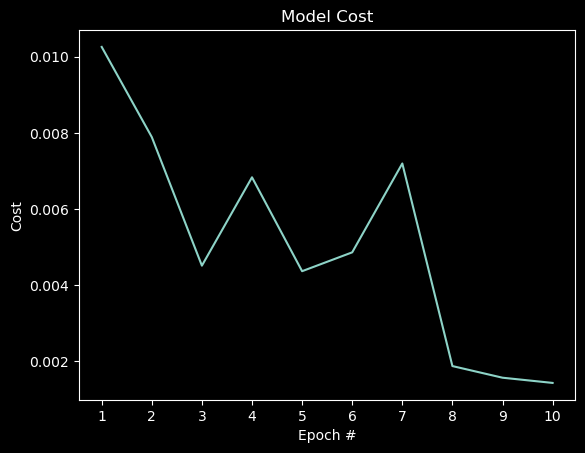

In [15]:
loss_plot(losses)

Because the model was able to train itself so quickly through the different batches in the first epoch, there is little difference in the resulting epoch which appear as random fluctuations.

Now that I have a trained model on 75% of the data, I can use the last 25% of the data as a cross validational (cv) dataset to test the model.

In [17]:
eval_model(X_test, y_te, nnettrain)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    243103
           1       1.00      1.00      1.00    981505

    accuracy                           1.00   1224608
   macro avg       1.00      1.00      1.00   1224608
weighted avg       1.00      1.00      1.00   1224608



Wow. The model was perfect. Sometimes I have run this model and it has had a few mistakes because the deep learning process isn't deterministic. It is possible for the gradient descent algorithm to get caught in local minima and never find the global minima. Now that I know that this model is very effective for this dataset I will use the entire dataset to train for the official test set.

Pytorch ended up being far faster as the predictions took significantly less time because it uses a dynamic computational graph instead of the static graph that tensorflow uses. The dynamic graph changes the architecture of model to be more efficient in evaluation but it may lead to different results in some cases. As far as I can tell there is no significant difference between the two packages. 

Below I ran the training on the entire 12 feature dataset with this current neural net

In [18]:
nnetsmall = train_model(X_small, y_train, 10, 5000, Net)

This model was perfect in cross validation and has now been trained on the entirety of the training dataset. I will now save the model so that I or anyone else can access it for future use.

In [19]:
# Save the model to the model folder
torch.save(nnetsmall, './models/nnetsmall.pth')

Below I loaded the model in so that I don't have to train it everytime I use the notebook

In [159]:
# Load the model so that I don't keep having to compute the model
nnetsmall = torch.load('./models/nnetsmall.pth')
# Evaluate the madel with the test set
eval_model(X_small_test, y_test, nnetsmall)

              precision    recall  f1-score   support

           0       0.73      0.84      0.78     60592
           1       0.96      0.92      0.94    250436

    accuracy                           0.91    311028
   macro avg       0.85      0.88      0.86    311028
weighted avg       0.92      0.91      0.91    311028



At first glance this appears promising, The model is not only better than a coinflip, It is also better than a null model where the model would predict the most frequent class every time. To better understand this result I will find the percentage of observations that are an intrusion.

In [21]:
# Store the unique values and their counts in separate variables
vals, counts = np.unique(y_test, return_counts = True)
# Create value_counts(normalize=True) for np array
prop_counts = counts/len(y_test)
# print the % of observations with no intrusion
print(f'No Intrusion: {round(prop_counts[0]*100, 1)}%')
# print the % of observations with an intrusion
print(f'Intrusion: {round(prop_counts[1]*100,1)}%')

No Intrusion: 19.5%
Intrusion: 80.5%


Above we see that only 19.5% of the test set is safe. If I had predicted an intrusion every time, the classification report would have had a precision of 80 for intrusion, 100 for recall intrusion and zeroes on everything for no intrusion. 

The accuracy scores show that this model is providing important value as they would be 50 if the model guessed intrusion every time. It is also important to note that the test set contains new intrusion types that aren't like the training set. Given the very high training scores, if I had a dataset that didn't have the new intrusion types this model would have been nearly perfect.

To get a better understanding of how well the model performed I can use the Reciever under the Curve metric which measures the True Positive Rate (TPR) against the False Positive Rate (FPR). A ROC area of greater that 0.8 is good and an ROC curve of 0.9 or greater is excellent.

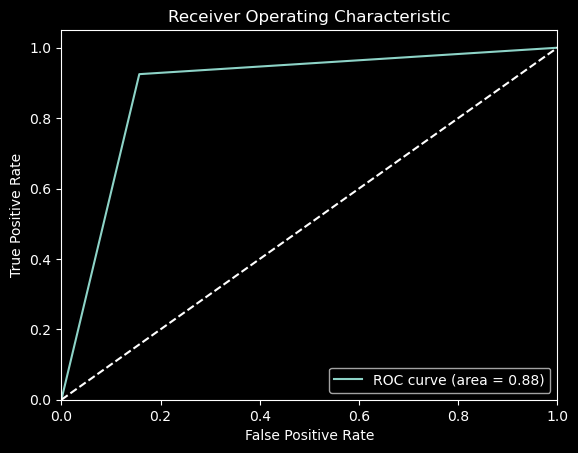

In [22]:
# compute the false positive rate, true positive rate, and threshold for normal observations
fpr, tpr, thresholds = roc_curve(y_test, preds)

# calculate the AUC
roc_auc = auc(fpr, tpr)

# plot the ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc);
# Plot the baseline 50-50 dashed line
plt.plot([0, 1], [0, 1], '--', color = 'w');
# Set the x axis limits
plt.xlim([0.0, 1.0]);
# Set the y axis limits
plt.ylim([0.0, 1.05]);
# Label the x-axis
plt.xlabel('False Positive Rate');
# Label the y-axis
plt.ylabel('True Positive Rate');
# Title the plot
plt.title('Receiver Operating Characteristic');
# Create the legend that has the area under the curve
plt.legend(loc="lower right");
# Show the graph
plt.show();

An ROC curve of .88 is really good but not great. 

There is a deeper issue with this result which is that when I compare it to the cv dataset there is a clear drop off. The most likely explanation for this is that the model failed to effectively predict that that the new attacks were not safe. This was the primary challenge of the Capstone and it appears that the model was not able to do an effective job.

Below I have isolated all the observations in the test set that are new attack types to see how the model performed against them.

In [89]:
# Create a mask for all values that are in new attacks in the test set
mask = small_test['labels'].isin(new_attacks)
# Use the mask to find all the prediction values that are from new labels
preds_new = preds[mask]
# Store the value count for the predictions
values, counts = np.unique(preds_new, return_counts = True)
# Print out the percent that is true positive
print(f"Percent of correctly identified new intrusions: {round((counts[1]/len(preds_new))*100, 2)}%")

Percent of correctly identified new intrusions: 14.38%


This is not good. Out of all the observations that had new attack types, only 14.38% were correctly classified by the model as an attack. 

To further investigate, I looked at which new attack types the model was best at predicting and which attack types the model struggled with.

In [218]:
deep_dive = ints_eval(preds, y_test)
# Show the deep dive dataframe
deep_dive.sort_values(['% Correct','Net'], ascending = False)

,Correct,Wrong,Net,% Correct
xsnoop.,4,0,4,100.0
sqlattack.,2,0,2,100.0
apache2.,790,4,786,99.5
processtable.,729,30,699,96.0
saint.,701,35,666,95.2
xlock.,4,5,-1,44.4
ps.,7,9,-2,43.8
named.,7,10,-3,41.2
xterm.,5,8,-3,38.5
sendmail.,5,12,-7,29.4


I believe that the varying efficiency of the model is because there is a wide range in similarity between some of the new attacks, and the training attacks that the model evaluated. For snmpgetattack, mailbomb and snmpguess there weren't a lot of intrusions that had the same signature as them. Since the non intrusion classification most likely doesn't have any specific markers without the data to train for these kinds of attacks the model thought they weren't an intrusion. 

There is a fundamental problem in this challenge which is that it is impossible to train for what has never happened. These models are great at predicting the future based on the patterns of the past but when they are unable to see any future patterns in the information that they are given then the algorithm will fail. This is why white hat hackers and previous datasets are so important because they can inform us about the threats that aren't in the current dataset.

One last test to see if this is still a viable model is to split the official test set in to training and testing data and see how the model performs on that test data. If this were a company or the government eventually the test data would be turned into training data as more data is expected to arrive.

In [138]:
# Create a train and test data from the 12 feature dataset
X_test_train, X_test_test, y_test_tr, y_test_te = train_test_split(X_small_test, y_test, test_size = .25, random_state = 42)

Now I train the model with the same model architecture that I have been using but a large portion of the test set as the training set.

In [311]:
nnettest = train_model(X_test_train, y_test_tr, 10, 500, Net)

In [312]:
eval_model(X_test_test, y_test_te, nnettest)
preds_1 = preds

              precision    recall  f1-score   support

           0       0.84      0.96      0.89     15035
           1       0.99      0.96      0.97     62722

    accuracy                           0.96     77757
   macro avg       0.91      0.96      0.93     77757
weighted avg       0.96      0.96      0.96     77757



The accuracy is not near the training set accuracy which is disappointing. It appears that all the clear patterns that were in the training set are not fully in the test set. When I did lasso regularization, I did it only with the training set which did not have any of the new attacks. This current dataset is optimized for the attacks in the training set but not the attacks in the test set. 

Below I copied the preprocessing function, added lasso and ran it on the raw test data. I then combined the new columns that were selected by lasso with the old columns of the previous dataset to create a better dataset that if another prediction had to be made that model would do significantly better.

In [157]:
deep_dive = ints_eval(preds,y_test_te)
# Show the deep dive dataframe
deep_dive.sort_values(['% Correct','Net'], ascending = False)

,Correct,Wrong,Net,% Correct
mscan.,264,0,264,100.0
processtable.,197,0,197,100.0
xterm.,4,0,4,100.0
mailbomb.,1202,1,1201,99.9
apache2.,209,1,208,99.5
httptunnel.,47,1,46,97.9
saint.,174,4,170,97.8
ps.,4,1,3,80.0
named.,3,1,2,75.0
sendmail.,2,1,1,66.7


The snmp intrusions from this dataset appear to be the exact same as no intrusion. In my cluster analysis I explored how a combination of different traits can lead to some stark conclusions about the type of intrusion the observation is. I can look at all the snmp intrusions and compare them to the clusters that had the highest normal probability.

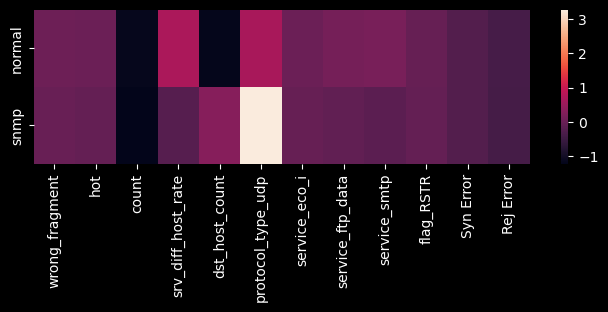

In [223]:
# Create groupby object
normal_mean = pd.DataFrame(small_test.loc[small_test['labels'] == 'normal.'].mean(numeric_only = True))
# Change the figure size to fit the dataframe
plt.figure(figsize=(8,2))
# filter out all observations that are snmp attacks
snmp = pd.DataFrame(small_test.loc[small_test['labels'].str.startswith('snmpg')].mean(numeric_only = True))
# combine the two
combined = pd.concat([normal_mean, snmp], axis = 1)
# Label the indices to know which is which
combined.columns = ['normal', 'snmp']
# create a heatmap of the means to visualize it better
sns.heatmap(combined.T);

The heatmap looks like there should be enough for snmp to classified correctly by the model as protocol_type_udp which would appear to be significantly different in SNMP. What most likely happened was that the model discarded protocol_type_udp during training as it didn't have a significant impact on the training intrusions. If I create a sequential second layer that re-examines all of the observations that the model predicted were safe, I can hopefully catch some obscurred patterns in the rarer intrusion types that could significantly improve the model.

Below I separate out the test data into the safe predictions that the model made.

In [313]:
# Create a mask for all the safe values
safe_preds = preds_1 == 0
# Apply the mask to the X data
X_layer2 = X_test_test[safe_preds]
# Apply the mask to the y data
y_layer2 = y_test_te[safe_preds]
# Use train_test_split to generate train and test sets
X2_train, X2_test, y2_train, y2_test = train_test_split(X_layer2, y_layer2, test_size = .25, random_state=25)

In [306]:
# Run the model with large batch and epochs
layer2 = train_model(X2_train, y2_train, 1000, 1000, Net)

The loss and accuracy here are surprisingly bad.

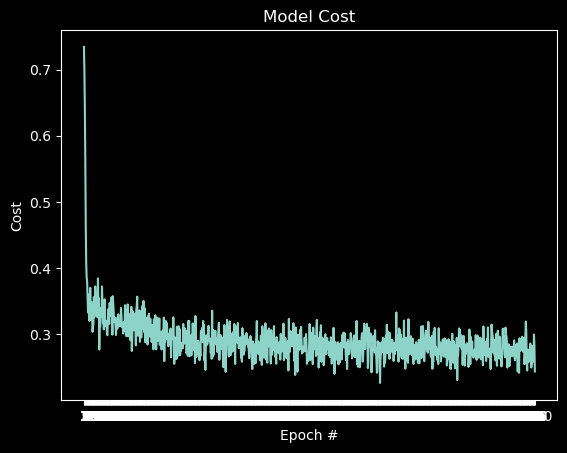

In [307]:
# Plot the losses
loss_plot(losses)

There are so many epochs that the x-ticks are illegible. There is a slight downward trend throughout the graph but most likely it stops around 500 epochs.

In [308]:
eval_model(X2_test, y2_test, layer2)

              precision    recall  f1-score   support

           0       0.84      0.98      0.91      3714
           1       0.71      0.18      0.29       830

    accuracy                           0.84      4544
   macro avg       0.78      0.58      0.60      4544
weighted avg       0.82      0.84      0.80      4544



This is significantly worse than what 

In [314]:
l2_preds = []
j = 0
for i in range(len(y_test_te)):
    if safe_preds[i] == True: 
        l2_preds.append(preds[j])
        j +=1
    else:
        l2_preds.append(0)
l2_preds = np.array(l2_preds,dtype = object)
preds_1 = np.array(preds_1).reshape(-1)
full_pred = np.add(preds_1, l2_preds).astype(int)
print(classification_report(y_test_te['Binary'], full_pred))

              precision    recall  f1-score   support

           0       0.83      0.21      0.34     15035
           1       0.84      0.99      0.91     62722

    accuracy                           0.84     77757
   macro avg       0.84      0.60      0.62     77757
weighted avg       0.84      0.84      0.80     77757



In [315]:
deep_dive = ints_eval(l2_preds, y2_test, mask = False)
deep_dive

,Correct,Wrong,Net,% Correct
normal.,653,2960,-2307,18.1
snmpgetattack.,78,402,-324,16.2
snmpguess.,27,108,-81,20.0
satan.,4,18,-14,18.2
guess_passwd.,3,16,-13,15.8
mailbomb.,1,0,1,100.0
pod.,1,0,1,100.0
named.,1,0,1,100.0
warezmaster.,0,6,-6,0.0
smurf.,0,3,-3,0.0


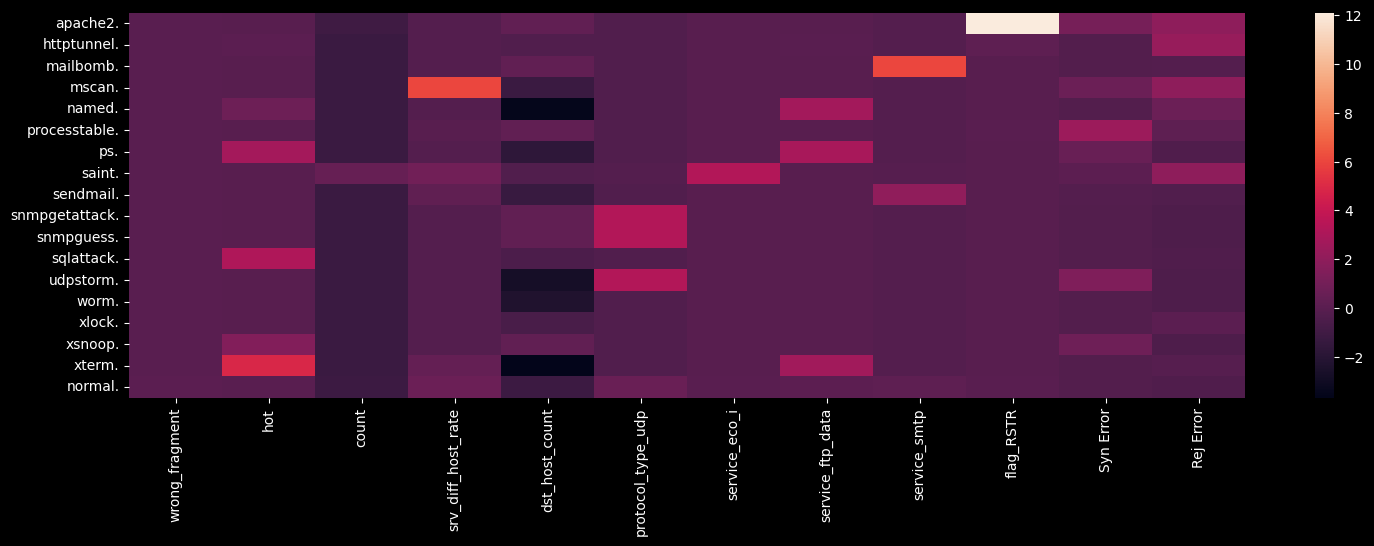

In [339]:
# Create groupby object
normal_mean = pd.DataFrame(small_test.loc[small_test['labels'] == 'normal.'].mean(numeric_only = True), columns = ['normal.'])
# Change the figure size to fit the dataframe
plt.figure(figsize=(18,5))
# filter out all observations that are snmp attacks
snmp = pd.DataFrame(small_test.loc[small_test['labels'].isin(new_attacks)])
grouped = pd.DataFrame(snmp.groupby('labels').mean(numeric_only = True).T)
# combine the two
combined = pd.concat([grouped, normal_mean], axis = 1)
# create a heatmap of the means to visualize it better
sns.heatmap(combined.T);


In [370]:
def lassoing(dfx):
    # I copy and pasted the column names from the website into this list
    dfx.columns = ["duration", "protocol_type", "service", "flag", "src_bytes",
                    "dst_bytes", "land", "wrong_fragment", "urgent", "hot",
                    "num_failed_logins", "logged_in", "num_compromised",
                    "root_shell", "su_attempted", "num_root", "num_file_creations",
                    "num_shells", "num_access_files", "num_outbound_cmds", "is_host_login",
                    "is_guest_login", "count", "srv_count", "serror_rate","srv_serror_rate",
                    "rerror_rate", "srv_rerror_rate", "same_srv_rate", "diff_srv_rate", "srv_diff_host_rate",
                    "dst_host_count", "dst_host_srv_count", "dst_host_same_srv_rate", "dst_host_diff_srv_rate",
                    "dst_host_same_src_port_rate", "dst_host_srv_diff_host_rate", "dst_host_serror_rate", 
                    "dst_host_srv_serror_rate", "dst_host_rerror_rate", "dst_host_srv_rerror_rate", "labels"]
    
    # Between 'num_outbound_cmds', and 'is_host_login' there are 2 non zero values both are observations that were both normal.
    # Use the drop methods to get rid of the near constants
    dfx = dfx.drop(columns = ['num_outbound_cmds', 'is_host_login'], axis = 1)
    '''
    Now we separate the data into the feature variables (X) and the target variable (y). With the features dataframe we can use 
    the pd.get_dummies function to create dummy features for all the categories in the categorical columns. This will make it possible 
    to analyze all the features for multicolinearity and then use lasso regularization to determine the most important features.
    '''
    # Only use the X data so that it is easy to test for multicolinearity
    y = np.where(dfx['labels'] == 'normal.', 0, 1)
    # drop the target variable from the feature set
    X_data = dfx.drop('labels', axis = 1)

    # Find the categorical columns that need to be made numerical for analysis
    cat_cols = list(X_data.select_dtypes(include = 'object').columns)

    # Creating a completely numerical dataset that is usable for analysis
    X_data = pd.get_dummies(X_data, columns = cat_cols, 
                            # When testing for multi-co-linearity it is important to drop one of the dummies
                            # so that that column doesn't get flagged
                                drop_first = True)
    
    '''
    Skewed features are a problem as they make it hard for models to accurately describe interactions between different features because
    the arbitrary size of some feature will completely warp the math. To fix this we can scale the features with StandardScaler so as to
    preserve the nature of the feature without destroying the model by its size.
    '''
    # Create the scaler object
    scaler = StandardScaler()
    # fit the scaler to the dataset
    scaler.fit(X_data)
    # Scale the dataset
    X_data = pd.DataFrame(scaler.transform(X_data), columns = X_data.columns)

    '''
    Creating the features 'Syn Error' and 'Rej Error'
    '''
    # Define the Syn Error columns
    serror = ['serror_rate', 'srv_serror_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate']

    # Define the Syn Error columns
    rerror = ['rerror_rate', 'srv_rerror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate']

    # Create new Syn Error column as mean of the former Syn Error columns
    X_data['Syn Error'] = X_data[serror].max(axis = 1)


    # Create new Syn Error column as mean of the former Syn Error columns
    X_data['Rej Error'] = X_data[rerror].max(axis = 1)


    # Drop the redundant columns
    X_data = X_data.drop(columns = [*serror, *rerror])
    
    # Find the coefficients of lasso regularization
    lasso = Lasso(alpha = 0.007157894736842105)
    # Fit the lasso regularization to the data 
    lasso.fit(X_data,y)
    # Create a list of all the features that don't have a lasso coefficient of zero
    test_features = [X_data.columns[i] for i in range(len(X_data.columns)) if list(lasso.coef_)[i] != 0]

    # Create the list of all important training features
    train_features = list(X_small.columns)
    # Create join the lists.
    train_test_features = list(set(train_features) | set(test_features))
    # Return the dataset that has only the lasso test features.
    return X_data[train_test_features]

In [371]:
# Import the test data
test = pd.read_csv('./data/raw/test')

Opt_test = lassoing(test)
Opt_test.head()

,service_eco_i,hot,flag_SF,count,protocol_type_udp,flag_RSTR,service_http,service_urp_i,logged_in,service_pop_3,...,service_smtp,Syn Error,dst_host_same_src_port_rate,service_finger,service_domain_u,wrong_fragment,service_ecr_i,dst_host_count,srv_diff_host_rate,Rej Error
0,-0.041974,-0.047032,0.502232,-1.220230,3.263145,-0.053023,-0.390958,-0.014234,-0.456536,-0.113735,...,-0.165254,-0.252083,-1.113746,-0.030602,-0.101312,-0.018877,-1.058542,0.323696,-0.202418,-0.408486
1,-0.041974,-0.047032,0.502232,-1.220230,3.263145,-0.053023,-0.390958,-0.014234,-0.456536,-0.113735,...,-0.165254,-0.252083,-1.113746,-0.030602,-0.101312,-0.018877,-1.058542,0.323696,-0.202418,-0.408486
2,-0.041974,-0.047032,0.502232,-1.215681,3.263145,-0.053023,-0.390958,-0.014234,-0.456536,-0.113735,...,-0.165254,-0.252083,-1.113746,-0.030602,-0.101312,-0.018877,-1.058542,0.323696,-0.202418,-0.408486
3,-0.041974,-0.047032,0.502232,-1.215681,3.263145,-0.053023,-0.390958,-0.014234,-0.456536,-0.113735,...,-0.165254,-0.252083,-1.093419,-0.030602,-0.101312,-0.018877,-1.058542,0.323696,-0.202418,-0.408486
4,-0.041974,-0.047032,0.502232,-1.215681,3.263145,-0.053023,-0.390958,-0.014234,-0.456536,-0.113735,...,-0.165254,-0.252083,-1.093419,-0.030602,-0.101312,-0.018877,-1.058542,0.323696,-0.202418,-0.408486


In [ ]:
Xopt_train, X_opt_test, y_opt_tr, y_opt_tr = train_test_split(Opt_test, y_test_binary, test_size = 0.25, random_state = 54)
opt_model = train_model(Xopt_train, y_opt_tr, 10, 500, Net)

#### **Categorical Models**

As helpful

#### **Big Data**

Now is the chance to use the bigger dataset that is supposed to contain every features that can help distinguish between the intrusion types.

In [35]:
# Create a train and test data from the full dataset
X_train, X_test, y_tr, y_te = train_test_split(X_big, small_train['group'], test_size = .25)

In [36]:
def change_labels(y_train):
    # Initialize the label encoder
    label_encoder = LabelEncoder()
    # fit and transform the y training data with label encoder
    y_group = label_encoder.fit_transform(y_train)
    # transfrom the encoded data to a categorical variable
    y_group = to_categorical(y_group, num_classes = 8)
    # return the labels for outside the function
    return y_group

In [37]:
y_group = change_labels(y_tr)

In [38]:
def tf_model(X_train, y_train, ep, b_s):
    # Initialize the model
    model = Sequential()

    # Create the first layer of the deep learning model with input set the number of features in X_train
    model.add(Dense(61, activation = 'relu', input_dim = X_train.shape[1]))
    # Add a middle layer to give the model more complexity
    model.add(Dense(61, activation = 'relu'))
    # Add a middle layer to give the model more complexity
    model.add(Dense(61, activation = 'relu'))
    # Add a middle layer to give the model more complexity
    model.add(Dense(61, activation = 'relu'))
    # Add a middle layer to give the model more complexity
    model.add(Dense(61, activation = 'relu'))
    # Add a middle layer to give the model more complexity
    model.add(Dense(61, activation = 'relu'))
    # Add a middle layer to give the model more complexity
    model.add(Dense(61, activation = 'relu'))
    # Add a middle layer to give the model more complexity
    model.add(Dense(61, activation = 'relu'))
    # Add a middle layer to give the model more complexity
    model.add(Dense(61, activation = 'relu'))
    # Add a middle layer to give the model more complexity
    model.add(Dense(53, activation = 'relu'))
    # Add a middle layer to give the model more complexity
    model.add(Dense(38, activation = 'relu'))
    # Add a middle layer to give the model more complexity
    model.add(Dense(25, activation = 'relu'))
    # Add a middle layer to give the model more complexity
    model.add(Dense(14, activation = 'relu'))
    # Finish with the same amount of nodes as categories that there are to predict
    model.add(Dense(8, activation = 'softmax'))
    # Compile the network with the standard optimiizer and loss function
    model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['binary_accuracy'])
    # Train the model with X_train and the encoded categorical y_group
    model.fit(X_train.astype('float32'), y_train, epochs = ep, batch_size = b_s)

    return model


In [39]:
bignet = tf_model(X_train, y_group, 2, 5000)

Epoch 1/2
735/735 [==============================] - 61s 78ms/step - loss: 0.0689 - binary_accuracy: 0.9838
Epoch 2/2
735/735 [==============================] - 69s 94ms/step - loss: 9.2383e-04 - binary_accuracy: 0.9998


In [40]:
def eval_tf(X_test, y_test, model):
    # Create the predictions. This creates an array that has as many columns as potential predictions
    preds = model.predict(X_test)
    # Take the highest prediction as the model's prediction
    pred = preds.argmax(axis = 1)
    # get the intrusions corresponding to the encoder class.
    ints = label_encoder.classes_ # type: ignore
    # Assign each of the predictions to the group that they correspond to
    predictions = [ints[i] for i in pred]
    # Print out the classification report
    print(classification_report(y_test, predictions, zero_division = 0))

In [42]:
eval_tf(X_test, y_te, bignet)

38269/38269 [==============================] - 61s 2ms/step
              precision    recall  f1-score   support

 brute force       0.00      0.00      0.00        27
       files       0.00      0.00      0.00         8
    internal       1.00      1.00      1.00    703113
        none       1.00      1.00      1.00    242849
       pings       1.00      1.00      1.00    268073
     scripts       0.00      0.00      0.00         4
      sweeps       0.99      0.97      0.98     10274
       warez       0.00      0.00      0.00       260

    accuracy                           1.00   1224608
   macro avg       0.50      0.50      0.50   1224608
weighted avg       1.00      1.00      1.00   1224608



This was slightly more precise than the previous model where the sweeps group was nearly perfect. Now lets see how it performs on the official test set.

Overall the neural networks were amazing at predicting intrusion types that had already happened. If this model was to be used at a security firm than the more diverse set of intrusions that it was allowed to train on the better it would do. Unfortunately there are a set of attacks that without training data is impossible for this model to catch. I don't know if there is a better way to train the model to catch them.

The one thing that I wish I had done better was to get the model to generate more rare events. Given the size of the dataset and the rarety of some of the intrusion types the models just ignored those types and stuck with the more common intrusion types. If I had weighted the model and created some synthetic data with some of the rarer intrusion types that might have helped the model predict all intrusion types.

In [44]:
y_group = change_labels(small_train['group'])
bigNet = tf_model(X_big, y_group, 2, 5000)

Epoch 1/2
980/980 [==============================] - 75s 76ms/step - loss: 0.0268 - binary_accuracy: 0.9942
Epoch 2/2
980/980 [==============================] - 81s 82ms/step - loss: 8.2705e-04 - binary_accuracy: 0.9998


In [45]:
eval_tf(X_big_test, small_test['group'], bigNet)

9720/9720 [==============================] - 16s 2ms/step
              precision    recall  f1-score   support

 brute force       0.00      0.00      0.00      7574
       files       0.00      0.00      0.00         5
    internal       0.96      0.99      0.98    165217
        none       0.70      0.89      0.79     60592
       pings       0.99      0.92      0.95     63109
     scripts       0.00      0.00      0.00      8763
      sweeps       0.78      0.70      0.74      4166
       warez       0.25      0.14      0.18      1602

    accuracy                           0.90    311028
   macro avg       0.46      0.46      0.45    311028
weighted avg       0.86      0.90      0.88    311028



In [67]:
bigNet.save('./models/bigNet.h5')

### **Random Forrest**

The second type of model that I will use is random forrest which is an ensemble method of decision trees. The idea is that since hacking is an inherently human act, the process should follow some sort of decision tree where certain features being elevated or lowered should lead to certain types of intrusions. I did not have enough time to conduct a grid search or random search so I just did the basic version of a Random Forest Classifier.

In [61]:
# Initialize a random forest model
rf = RandomForestClassifier(n_jobs = 4)
# Create a set of values to search
param_grid = {'n_estimators': [5, 50, 100, 150, 200, 300, 600]}  
# Create the grid search object with 5 cross validational folds
grid_search = GridSearchCV(rf, param_grid, cv = 2, verbose = 1)  
# Fit the data to the grid search
grid_search.fit(X_small, y_train)
# Save the best parameters  
best_params = grid_search.best_params_
# Print the best parameters
best_params

Fitting 2 folds for each of 2 candidates, totalling 4 fits


{'n_estimators': 300}

In [65]:
# Create a train and test data from the 12 feature dataset
X_train, X_test, y_tr, y_te = train_test_split(X_small, y_train, test_size = .25, random_state = 42)

In [66]:
# Create a random forest classifier with the best parameters trees
rf = RandomForestClassifier(n_estimators= best_params['n_estimators'], n_jobs = 4)

# Fit the model to the data
rf.fit(X_train, y_tr)

# Predict the test set
rf_pred = rf.predict(X_test)

# print the classification report
print(classification_report(y_te, rf_pred, zero_division = 0))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    243103
           1       1.00      1.00      1.00    981505

    accuracy                           1.00   1224608
   macro avg       1.00      1.00      1.00   1224608
weighted avg       1.00      1.00      1.00   1224608



In [63]:
# Create a random forest classifier with the best parameters trees
rf = RandomForestClassifier(n_estimators= best_params['n_estimators'], n_jobs = 4)

# Fit the model to the data
rf.fit(X_small, y_train)

# Predict the test set
rf_pred = rf.predict(X_small_test)

# print the classification report
print(classification_report(y_test, rf_pred, zero_division = 0))

              precision    recall  f1-score   support

           0       0.70      0.86      0.77     60592
           1       0.96      0.91      0.94    250436

    accuracy                           0.90    311028
   macro avg       0.83      0.88      0.85    311028
weighted avg       0.91      0.90      0.90    311028



This is slightly worse than the neural network but it is very close. It could be that If the hyper parameters were correctly tuned that the results would be better. Below is a categorical random forrest.

This did significantly worse than the neural network. It is important to note that it recalled 99% of all the non intrusion observations but its precision was so low that has much less importance than the recall would indicate.

Below is the same but with the bigger dataset.

In [64]:
# Initialize the label encoder
label_encoder = LabelEncoder()
# fit and transform y_group
y_group = label_encoder.fit_transform(small_train['group']) #type: ignore
# Transform the y_group variable to a categorical variable
y_group = to_categorical(y_group, num_classes = 8)


# Create a random forest classifier with 100 trees
rf = RandomForestClassifier(n_estimators=best_params['n_estimators'], n_jobs = 4)

# Fit the model to the data
rf.fit(X_big, y_group)

# Predict the test dataset with the previous model
preds = rf.predict(X_big_test)
# Find the prediction that the model likes the most
pred = preds.argmax(axis = 1)
# Get the corresponding group types from label_encoder
ints = label_encoder.classes_
# find the intrusions for each prediction
predictions = [ints[i] for i in pred]
# Print the classification report
print(classification_report(small_test['group'], predictions, zero_division = 0))


              precision    recall  f1-score   support

 brute force       0.04      0.20      0.06      7574
       files       0.00      0.00      0.00         5
    internal       1.00      0.00      0.00    165217
        none       0.21      0.80      0.34     60592
       pings       0.98      0.24      0.39     63109
     scripts       0.00      0.00      0.00      8763
      sweeps       0.11      0.68      0.19      4166
       warez       1.00      0.13      0.23      1602

    accuracy                           0.22    311028
   macro avg       0.42      0.26      0.15    311028
weighted avg       0.78      0.22      0.15    311028



## **Conclusion**

From these results it is clear that the neural network model is the best model. With more time I could run a lot of hyper paramater tuning and investigate if taking the highest value soft max is the best decision or if maybe sometimes the model hints at something rarer that gets covered up by higher values of more common types. But until then the best model was the big data categorical model. It recalled 92% of all non intrusion observations and 71% precision while also giving valuable insight into the type of intrusion it was. This means that when the model predicted that there was an intrusion there was a 1-(.195*(1-.92)) = 98.4% chance that there was an intrusion.